# Task 2.1a - Creating the datasets

  Activating project at `~/Documents/MATH2504/Mitchell-Holt-2504-2023-PROJECT3`


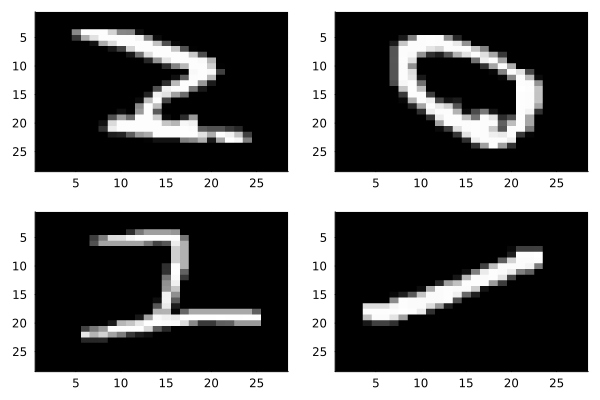

In [1]:
using Pkg; Pkg.activate(".")

using Plots, CSV, Tables, Random

# Paths to data
const fashion_mnist_train_path = "data/FashionMNIST/fashion-mnist_train.csv"
const fashion_mnist_rotations_train_path = begin
    "data/FashionMNIST/fashion-mnist-rotated_train.csv"
end
const fashion_mnist_test_path = "data/FashionMNIST/fashion-mnist_test.csv"
const fashion_mnist_rotations_test_path = begin
    "data/FashionMNIST/fashion-mnist-rotated_test.csv"
end
const mnist_train_path = "data/MNIST/mnist_train.csv"
const mnist_rotations_train_path = "data/MNIST/mnist-rotated_train.csv"
const mnist_test_path = "data/MNIST/mnist_test.csv"
const mnist_rotations_test_path = "data/MNIST/mnist-rotated_test.csv"

const img_dims = 28

const rotate_0_label = 0
const rotate_90_label = 1
const rotate_180_label = 2
const rotate_270_label = 3


# Identity function; indeed, the identity element of the monoid of functions of
# type a -> a
id(x) = x

# compose a map with itself k times (in the monoid of functions a -> a).
function compose(f :: Function, k :: Int)
    k < 0 && error("Cannot calculate inverse of an arbitrary function")
    return k == 0 ? id : f ∘ compose(f, k - 1)
end


# Rotate the matrix representation of the pixels in an image a quarter turn 
# counter-clockwise.
rotate_counter_clockwise(img) = mapslices(reverse, transpose(img); dims=1)


# Display an image from the training set
display_img(img) = heatmap(
    img;
    yflip = true, legend = false, c = cgrad([:black, :white]))


# Read all the data in the input CSV file, apply rotations and then save it to
# a CSV file
function transform_data(input_file_name :: String, output_file_name :: String;
        seed = 5)

    Random.seed!(seed)
    raw_data = Tables.matrix(
        CSV.File(input_file_name))
    # ignore existing labels, we will use our own
    imgs = [
        transpose(reshape(row[2:end], img_dims, img_dims))
        for row in eachrow(raw_data)
    ]
    transformed = [
        begin
            i = rand(0:3)
            (i, compose(rotate_counter_clockwise, 4 - i)(img))
        end
        for img in imgs
    ]
    # Plot example
    example = plot(map(x -> display_img(x[2]), transformed[1:4])...)
    # Save to csv
    out_matrix = Matrix{Int}(undef, length(transformed), (28 * 28) + 1)
    for k in 1:length(transformed)
        out_matrix[k, 1] = transformed[k][1]
        out_matrix[k, 2:end] = transformed[k][2]
    end
    CSV.write(output_file_name, Tables.table(out_matrix))
    return example
end


# Import transformed data from a given file
function import_transformed_csv(input_file_name :: String)
    raw_data = Tables.matrix(
        CSV.File(input_file_name)) # limit for debug, remove later
    return [
        (row[1], reshape(row[2:end], img_dims, img_dims))
        for row in eachrow(raw_data)
    ]
end


transform_data(mnist_train_path, mnist_rotations_train_path)

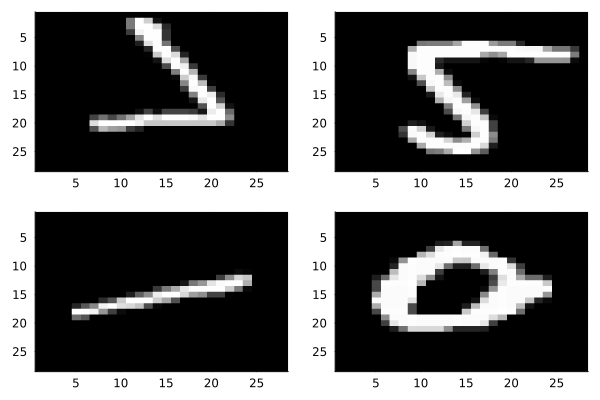

In [2]:
transform_data(mnist_test_path, mnist_rotations_test_path)

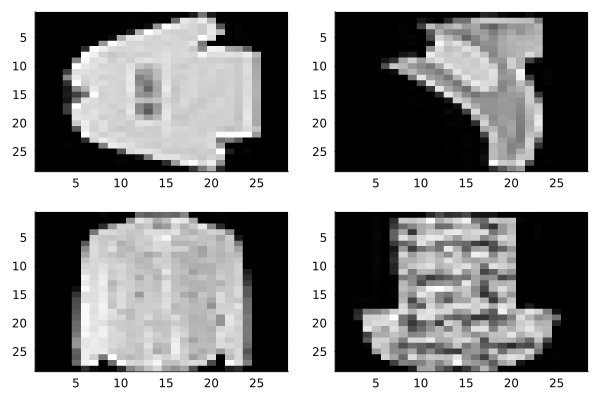

In [3]:
transform_data(fashion_mnist_train_path, fashion_mnist_rotations_train_path)

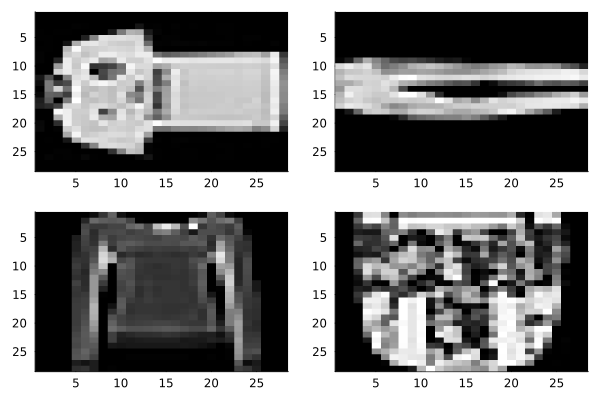

In [4]:
transform_data(fashion_mnist_test_path, fashion_mnist_rotations_test_path)

# Task 2.2a Using a linear classifier

In [5]:
using LinearAlgebra
using Flux: onehotbatch

labels = 0:3

fashion_train_data = import_transformed_csv(fashion_mnist_rotations_train_path)
fashion_test_data = import_transformed_csv(fashion_mnist_rotations_test_path)

train_data = import_transformed_csv(mnist_rotations_train_path)
test_data = import_transformed_csv(mnist_rotations_test_path)

function train_linear_model(train_data)
    train_labels = first.(train_data)
    train_images = last.(train_data)
    n_train = length(train_data)

    X = vcat(map(transpose ∘ vec, train_images)...)

    A = [ones(n_train) X]
    Adag = pinv(A)

    tfPM(x) = x ? +1 : -1
    yDat(k) = tfPM.(onehotbatch(train_labels, labels)'[:,k+1])
    # this is the trained model (a list of 4 beta coeff vectors)
    bets = [Adag*yDat(k) for k in labels]
end


function test_model(test_data, coeff_vec)
    test_labels = first.(test_data)
    test_images = last.(test_data)
    n_test = length(test_data)

    linear_classify(square_image) = argmax(
        [([1 ; vec(square_image)])'*coeff_vec[k] for k in 1:4])-1

    predictions = linear_classify.(test_images)
    confusionMatrix = [
        sum((predictions .== i) .& (test_labels .== j)) for i in labels, j in labels
    ]
    return sum(diag(confusionMatrix))/n_test
end

mnist_acc = test_model(test_data, train_linear_model(train_data))
fashion_mnist_acc = test_model(fashion_test_data, train_linear_model(fashion_train_data))
println("MNIST accuray: $mnist_acc")
print("Fashion MNIST accuracy: $fashion_mnist_acc")

MNIST accuray: 0.9618
Fashion MNIST accuracy: 0.8818

# Task 2.3a Using a linear classifier

In [8]:
using Flux, Statistics, Random, StatsBase, Plots
using Flux: params, onehotbatch, crossentropy, update!

logistic_softmax_predict(img_vec, W, b) = softmax(W*img_vec .+ b)
logistic_sofmax_classifier(img_vec, W, b) = argmax(
    logistic_softmax_predict(img_vec, W, b)) - 1


function train_softmax_logistic(train_data, test_data, target_acc;
        mini_batch_size = 1000, seed = 0)

    Random.seed!(seed)

    train_labels = first.(train_data)
    train_images = last.(train_data)
    n_train = length(train_data)

    test_labels = first.(test_data)
    # test_images = last.(test_data)
    n_test = length(test_data)

    X_test = vcat(map(transpose ∘ vec, train_images)...)
    X = vcat(map(transpose ∘ vec, train_images)...)

    #Initilize parameters
    W = randn(4, 28*28)
    b = randn(4)

    opt = ADAM(0.01)
    loss(x, y) = crossentropy(
        logistic_softmax_predict(x, W, b), onehotbatch(y, 0:3))

    loss_value = 0.0
    epoch_num = 0

    #Training loop
    while true
        prev_loss_value = loss_value
        
        #Loop over mini-batches in epoch
        start_time = time_ns()
        for batch in Iterators.partition(1:n_train, mini_batch_size)
            gs = gradient(
                ()->loss(X'[:,batch], train_labels[batch]), params(W,b))
            for p in (W,b)
                update!(opt, p, gs[p])
            end
        end
        end_time = time_ns()

        #record/display progress
        epoch_num += 1
        loss_value = loss(X', train_labels)
        println("Epoch = $epoch_num ",
            "($(round((end_time-start_time)/1e9,digits=2)) sec) ",
            "Loss = $loss_value")
        
        if epoch_num == 1 || epoch_num % 5 == 0 
            acc = mean(
                [
                    logistic_sofmax_classifier(X_test'[:,k], W, b)
                    for k in 1:n_test
                ] .== test_labels)
            println("\tValidation accuracy: $acc") 
            
            #Stopping criteria
            if abs(prev_loss_value-loss_value) < 1e-3 || acc > target_acc
                break
            end
        end
    end
    return W, b
end

train_softmax_logistic(train_data, test_data, mnist_acc)

Epoch = 1 (12.51 sec) Loss = 17.51732300338567
	Validation accuracy: 0.5131
Epoch = 2 (6.6 sec) Loss = 14.797008496786425
Epoch = 3 (6.59 sec) Loss = 11.670314432090528
Epoch = 4 (6.55 sec) Loss = 9.785224286312555
Epoch = 5 (6.7 sec) Loss = 8.407105754723851
	Validation accuracy: 0.7628
Epoch = 6 (6.66 sec) Loss = 7.025841422764243
Epoch = 7 (6.68 sec) Loss = 5.537814295548805
Epoch = 8 (6.68 sec) Loss = 4.858503753352069
Epoch = 9 (6.71 sec) Loss = 4.2325095670832145
Epoch = 10 (6.69 sec) Loss = 3.90096291369704
	Validation accuracy: 0.8912
Epoch = 11 (6.67 sec) Loss = 3.540818836745572
Epoch = 12 (6.68 sec) Loss = 3.6151475743003996
Epoch = 13 (6.76 sec) Loss = 3.15686489734693
Epoch = 14 (6.66 sec) Loss = 2.9458434236926365
Epoch = 15 (6.7 sec) Loss = 2.9309257713422587
	Validation accuracy: 0.9165
Epoch = 16 (7.95 sec) Loss = 2.6179952065531267
Epoch = 17 (8.81 sec) Loss = 2.489786157232681
Epoch = 18 (8.88 sec) Loss = 2.53985009684732
Epoch = 19 (9.03 sec) Loss = 2.28823606132189

([-0.23190906957695134 -0.05156184220322609 … 0.4481773869407111 0.5881703609530071; 0.940390210248594 1.1722448627021573 … 0.9258491155806569 1.0964222357010607; 0.5967616711335215 -1.696813019281842 … -1.2378284450460282 -0.7702709462364564; 1.9978240930577937 -2.1161459685604527 … -0.6827561160868458 -0.20605155263022384], [1.1110185543529152, 0.9617454549002769, -0.7989569437095144, 1.2285162197109682])

In [ ]:
train_softmax_logistic(fashion_train_data, fashion_test_data, fashion_mnist_acc)